In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

# Number of data points
NUM_SAMPLES = 1000

# Simulation parameters
m = 500  # Mass (kg)
b = 50   # Resistive coefficient (N-s/m)
K = 0.8  # Gain (m/s-%pedal)

# Time parameters
T_START = 0
T_END = 20
TIME_RANGE = int(T_END - T_START) # Absolute time 

# ODE solver parameters
ODE_SOLVER = 'RK45'

# Initial condition 
v_0 = 0.0
p_0 = 10 

# System dynamics
def system_dynamics(t,v,p) -> float:
    dv_dt=(-v*b+K*b*p)/m
    return dv_dt

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12, 3))
    plt.plot(sol.t, sol.y[0], label='Velocity')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.show()

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval)
    return sol

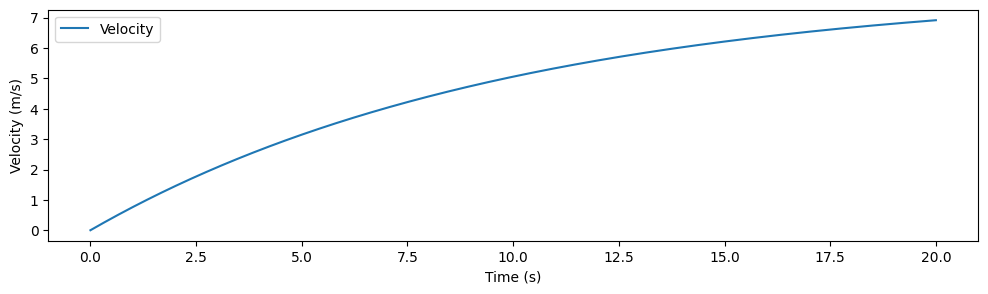

In [56]:
t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
solution = solve_ode(system_dynamics, 
                     t_span=[T_START, T_END], 
                     y0=[v_0], args=(p_0,), 
                     method=ODE_SOLVER, 
                     t_eval=t_eval)
plot_solution(solution)

In [61]:
# MPC parameters
dt = 0.5                         # Time step
L = int(TIME_RANGE / dt)         # Simulation steps
N_p = 7                         # Prediction horizon
Q = 10                            # Weight for tracking
R = 0.01                          # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'COBYLA'    # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

p_MIN = 0.0
p_MAX = 100
BOUNDS = [(p_MIN, p_MAX) for _ in range(N_p)]  # Bounds for pedal position
p_dmax=20

#V_set
x_sp=40

print(f'Number of steps: {L} and dt: {dt}')

Number of steps: 40 and dt: 0.5


In [62]:
# ----- Cost function -----
def cost_function(p_opt: list, x: float) -> float:
    J = 0
    for k in range(N_p):
        x_next = solve_ode(system_dynamics, t_span=[0, dt], y0=[x], method=ODE_SOLVER, t_eval=[dt], args=(p_opt[k],)).y[0][-1]
        J += Q * (x_sp - x_next) ** 2
        if k > 0:
            J += R * (p_opt[k] - p_opt[k - 1]) ** 2
        x = x_next
    return J

In [63]:
v = np.zeros(L)
p = np.zeros(L)

for i in tqdm(range(L-1)):
    res = minimize(cost_function, np.zeros(N_p), args=(v[i]), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    p_new = res.x[0]
    p[i + 1] = np.clip(p[i] + np.clip(p_new - p[i], -10, 10), 0, 100)  # Enforce Δp ≤ 20
    v[i + 1] = solve_ode(system_dynamics, t_span=[0, dt], y0=[v[i]], method=ODE_SOLVER, t_eval=[dt], args=(p[i + 1],)).y[0][-1]

100%|██████████| 39/39 [00:15<00:00,  2.45it/s]


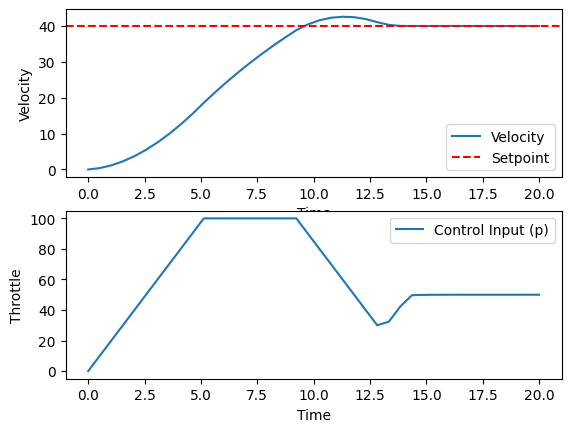

In [64]:
# Plot results
time = np.linspace(T_START, T_END, L)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, v, label="Velocity")
plt.axhline(y=x_sp, color='r', linestyle='--', label="Setpoint")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, p, label="Control Input (p)")
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.legend()

plt.show()


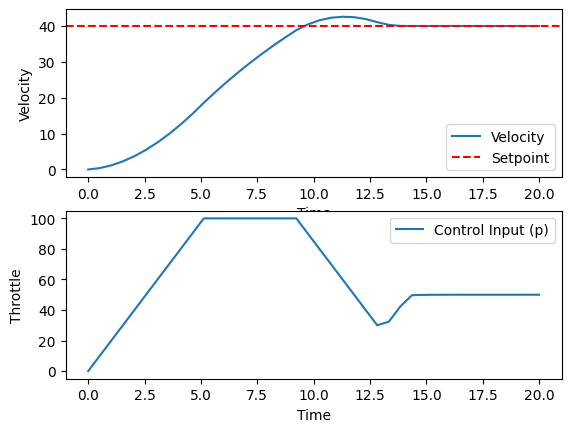

In [70]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, v, p_func) -> float:
    p = p_func(t)
    dv_dt=(-v*b+K*b*p)/m
    return dv_dt

# Solve plant model for varying feed rates
p_func = interp1d(time, p, kind='linear', fill_value='extrapolate')
sol = solve_ivp(simulate, [T_START, T_END], [v_0], args=(p_func,))

# Plot results
time = np.linspace(T_START, T_END, L)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, v, label="Velocity")
plt.axhline(y=x_sp, color='r', linestyle='--', label="Setpoint")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, p, label="Control Input (p)")
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.legend()

plt.show()
